In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gravats/camion-gravats-2tonnes.jpg
/kaggle/input/gravats/objectInfo150.csv
/kaggle/input/gravats/evacuation-gravats.jpg


In [2]:
from torchvision import models, transforms
from PIL import Image
import torch

# Load Pre-trained Model
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Preprocess Input Image
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = Image.open('/kaggle/input/gravats/camion-gravats-2tonnes.jpg')
input_tensor = preprocess(image).unsqueeze(0)

# Generate Mask
with torch.no_grad():
    output = model(input_tensor)['out'][0]
mask = output.argmax(0).byte().cpu().numpy()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 190MB/s]  


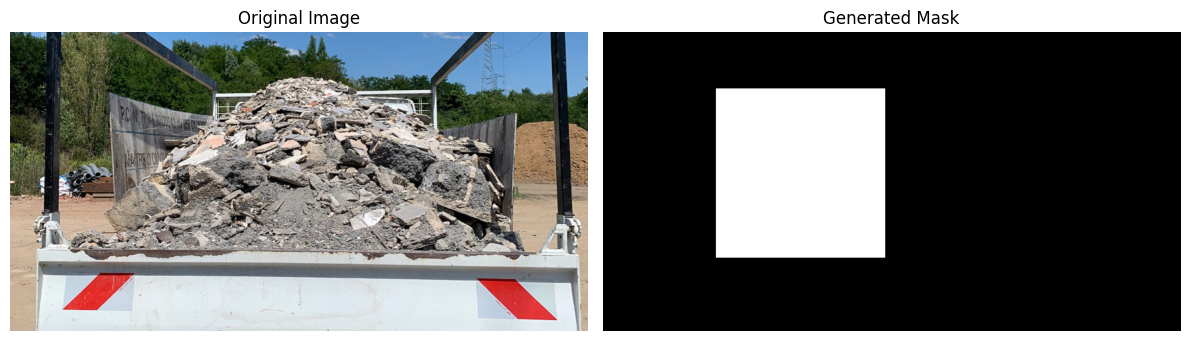

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the original image
original_image = Image.open('/kaggle/input/gravats/camion-gravats-2tonnes.jpg')  # Replace with your image path

# Simulate a generated mask for visualization
# Replace this with the actual mask generated by your segmentation model
mask = np.zeros((original_image.size[1], original_image.size[0]), dtype=np.uint8)
mask[100:400, 200:500] = 255  # Example mask region for demonstration

# Convert the mask to an image
mask_image = Image.fromarray(mask)

# Plot the original image and the mask side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Generated Mask")
plt.imshow(mask_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


# Approach 2: Unsupervised Clustering for Mask Generation

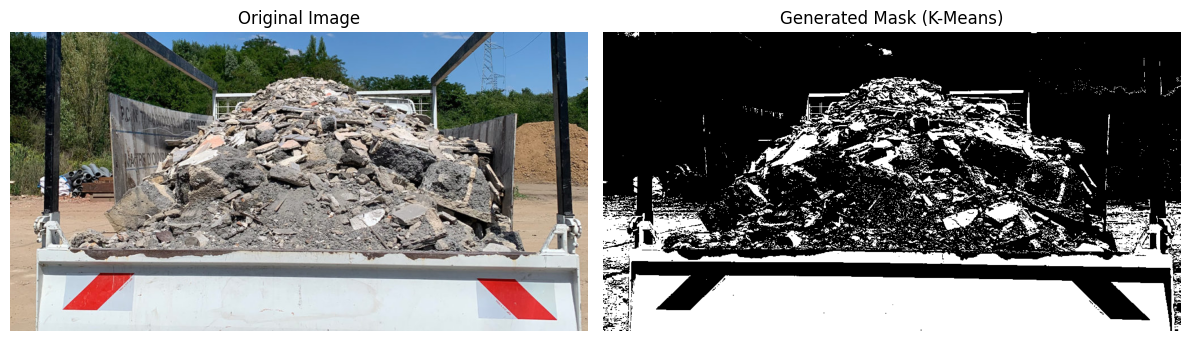

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image = cv2.imread('/kaggle/input/gravats/camion-gravats-2tonnes.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
reshaped = image_rgb.reshape((-1, 3))

# Apply K-Means Clustering
k = 3  # Number of clusters
_, labels, centers = cv2.kmeans(reshaped.astype(np.float32), k, None,
                                 criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                 attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS)

# Reshape labels to the image shape
labels = labels.reshape((image.shape[:2]))
gravat_cluster = 1  # Assume cluster 1 corresponds to gravat (can vary, test visually)
binary_mask = (labels == gravat_cluster).astype(np.uint8) * 255

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Generated Mask (K-Means)")
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


 # DeepLabV3

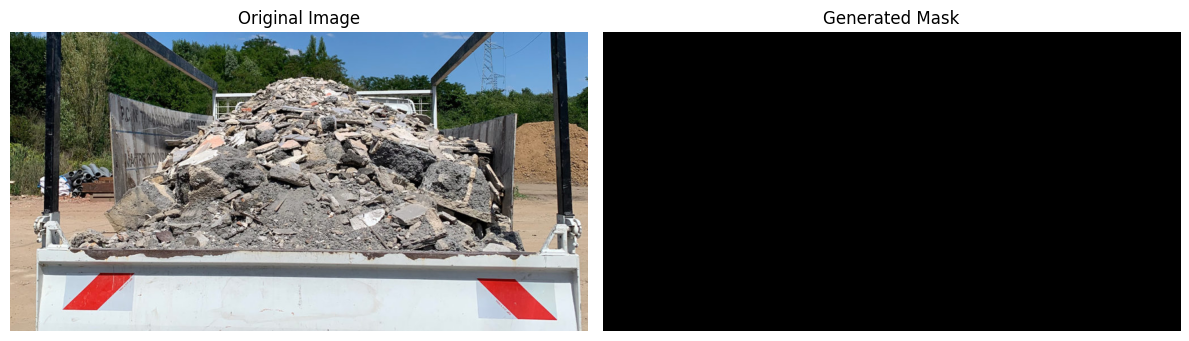

In [7]:
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the DeepLabV3 model pre-trained on COCO dataset
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Load and preprocess the input image
input_image = Image.open('/kaggle/input/gravats/camion-gravats-2tonnes.jpg')  # Replace with your image path
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image).unsqueeze(0)

# Run inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]
output_predictions = output.argmax(0).byte().cpu().numpy()

# Convert the segmentation to a binary mask for gravat-like areas
# Replace `target_class_id` with the class ID that resembles gravat (e.g., dirt, rubble)
target_class_id = 12  # Example class ID for "gravat-like" material (COCO)
binary_mask = (output_predictions == target_class_id)

# Resize the mask to the original image size
binary_mask_resized = Image.fromarray(binary_mask.astype('uint8') * 255).resize(input_image.size)

# Visualize the original image and the mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Generated Mask")
plt.imshow(binary_mask_resized, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


# Segmentation with NVIDIA SegFormer

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

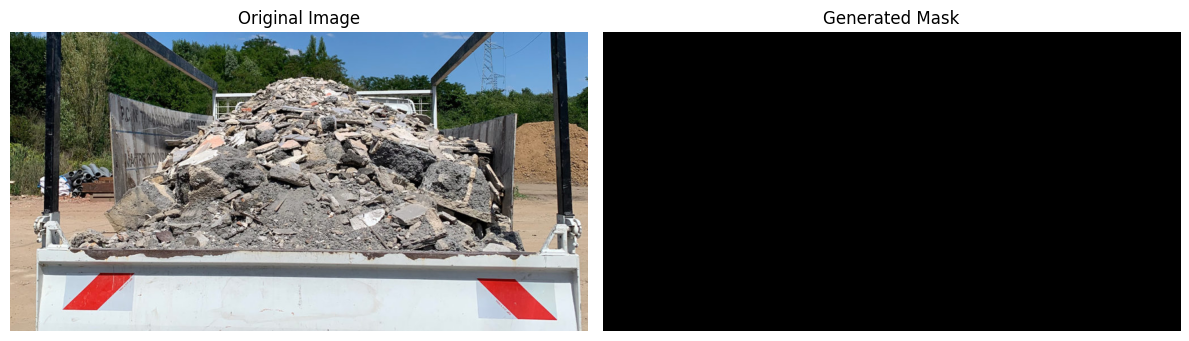

In [8]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the feature extractor and model
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Load and preprocess the input image
image_path = "/kaggle/input/gravats/camion-gravats-2tonnes.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape: [batch_size, num_classes, height, width]
    upsampled_logits = torch.nn.functional.interpolate(
        logits, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    predicted_class = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# Map the segmentation result to a binary mask for gravat (e.g., 'rock' class)
gravat_class_id = 124  # Replace with the class ID for gravat-like material
binary_mask = (predicted_class == gravat_class_id).astype(np.uint8) * 255

# Convert binary mask to a PIL image
binary_mask_image = Image.fromarray(binary_mask)

# Visualize the original image and the generated mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Generated Mask")
plt.imshow(binary_mask_image, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


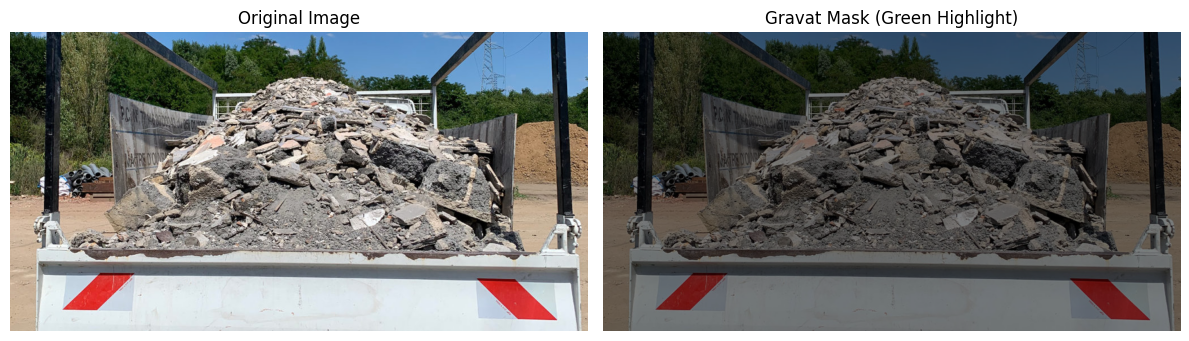

In [9]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the feature extractor and model
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Load and preprocess the input image
image_path = "/kaggle/input/gravats/camion-gravats-2tonnes.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape: [batch_size, num_classes, height, width]
    upsampled_logits = torch.nn.functional.interpolate(
        logits, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    predicted_class = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# Map the segmentation result to a binary mask for gravat (e.g., 'rock' class)
gravat_class_id = 124  # Replace with the class ID for gravat-like material
binary_mask = (predicted_class == gravat_class_id).astype(np.uint8)

# Create a color mask: Gravat in green, everything else in black
color_mask = np.zeros((image.size[1], image.size[0], 3), dtype=np.uint8)
color_mask[binary_mask == 1] = [0, 255, 0]  # Green for gravat

# Blend the color mask with the original image
original_image_np = np.array(image)
blended_image = original_image_np * 0.5 + color_mask * 0.5
blended_image = blended_image.astype(np.uint8)

# Visualize the original image and the mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Gravat Mask (Green Highlight)")
plt.imshow(blended_image)
plt.axis("off")

plt.tight_layout()
plt.show()


In [12]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import torch
import numpy as np

# Load the image processor and pre-trained model
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Load the input image
image_path = "/kaggle/input/gravats/camion-gravats-2tonnes.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Perform segmentation
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape: (batch_size, num_classes, height, width)
    upsampled_logits = torch.nn.functional.interpolate(
        logits, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    predicted_class = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# Get all unique class IDs present in the predicted segmentation
unique_classes = np.unique(predicted_class)
print("Unique classes detected in the image:", unique_classes)


Unique classes detected in the image: [ 0  1  2  4  8 12 13 14 20 22 32 34 40 41 43 93]


In [13]:
import pandas as pd

# Path to the CSV file
csv_path = "/kaggle/input/gravats/objectInfo150.csv"

# Load the CSV file into a DataFrame
class_mapping_df = pd.read_csv(csv_path)

# Create a dictionary for ID-to-Label mapping
id_to_label = dict(zip(class_mapping_df["Idx"], class_mapping_df["Name"]))

# Example detected class IDs from the segmentation model
detected_class_ids = [0, 1, 2, 4, 8, 12, 13, 14, 20, 22, 32, 34, 40, 41, 43, 93]

# Map class IDs to labels
mapped_labels = {class_id: id_to_label.get(class_id, "Unknown") for class_id in detected_class_ids}

# Print the mapping
print("Detected Classes and Their Labels:")
for class_id, label in mapped_labels.items():
    print(f"Class ID: {class_id}, Label: {label}")


Detected Classes and Their Labels:
Class ID: 0, Label: Unknown
Class ID: 1, Label: wall
Class ID: 2, Label: building;edifice
Class ID: 4, Label: floor;flooring
Class ID: 8, Label: bed
Class ID: 12, Label: sidewalk;pavement
Class ID: 13, Label: person;individual;someone;somebody;mortal;soul
Class ID: 14, Label: earth;ground
Class ID: 20, Label: chair
Class ID: 22, Label: water
Class ID: 32, Label: seat
Class ID: 34, Label: desk
Class ID: 40, Label: cushion
Class ID: 41, Label: base;pedestal;stand
Class ID: 43, Label: column;pillar
Class ID: 93, Label: apparel;wearing;apparel;dress;clothes


In [14]:
import pandas as pd
import numpy as np

# Path to the CSV file with ADE20K class mappings
csv_path = "/kaggle/input/gravats/objectInfo150.csv"

# Load the CSV file
class_mapping_df = pd.read_csv(csv_path)

# Create a dictionary mapping class IDs to labels
id_to_label = dict(zip(class_mapping_df["Idx"], class_mapping_df["Name"]))

# Example detected class IDs from Hugging Face model output
detected_class_ids = [0, 1, 2, 4, 8, 12, 13, 14, 20, 22, 32, 34, 40, 41, 43, 93]

# Map detected class IDs to labels
mapped_labels = {class_id: id_to_label.get(class_id, "Unknown") for class_id in detected_class_ids}

# Print the aligned class IDs and labels
print("Mapped Class IDs to Labels:")
for class_id, label in mapped_labels.items():
    print(f"Class ID: {class_id}, Label: {label}")


Mapped Class IDs to Labels:
Class ID: 0, Label: Unknown
Class ID: 1, Label: wall
Class ID: 2, Label: building;edifice
Class ID: 4, Label: floor;flooring
Class ID: 8, Label: bed
Class ID: 12, Label: sidewalk;pavement
Class ID: 13, Label: person;individual;someone;somebody;mortal;soul
Class ID: 14, Label: earth;ground
Class ID: 20, Label: chair
Class ID: 22, Label: water
Class ID: 32, Label: seat
Class ID: 34, Label: desk
Class ID: 40, Label: cushion
Class ID: 41, Label: base;pedestal;stand
Class ID: 43, Label: column;pillar
Class ID: 93, Label: apparel;wearing;apparel;dress;clothes


In [15]:
import pandas as pd

# Load the ADE20K class mappings
csv_path = "/kaggle/input/gravats/objectInfo150.csv"
class_mapping_df = pd.read_csv(csv_path)

# Create a dictionary mapping class IDs to labels
id_to_label = dict(zip(class_mapping_df["Idx"], class_mapping_df["Name"]))

# Example detected class IDs from the model output
detected_class_ids = [0, 1, 2, 4, 8, 12, 13, 14, 20, 22, 32, 34, 40, 41, 43, 93]

# Map detected class IDs to labels
mapped_labels = {class_id: id_to_label.get(class_id, "Unknown") for class_id in detected_class_ids}

# Print the mapped class IDs and labels
print("Mapped Class IDs to Labels:")
for class_id, label in mapped_labels.items():
    print(f"Class ID: {class_id}, Label: {label}")


Mapped Class IDs to Labels:
Class ID: 0, Label: Unknown
Class ID: 1, Label: wall
Class ID: 2, Label: building;edifice
Class ID: 4, Label: floor;flooring
Class ID: 8, Label: bed
Class ID: 12, Label: sidewalk;pavement
Class ID: 13, Label: person;individual;someone;somebody;mortal;soul
Class ID: 14, Label: earth;ground
Class ID: 20, Label: chair
Class ID: 22, Label: water
Class ID: 32, Label: seat
Class ID: 34, Label: desk
Class ID: 40, Label: cushion
Class ID: 41, Label: base;pedestal;stand
Class ID: 43, Label: column;pillar
Class ID: 93, Label: apparel;wearing;apparel;dress;clothes


In [1]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests

# Load the feature extractor and model
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

# First image (camion-gravats-2tonnes.jpg)

In [3]:
# Load an image from a URL or local path
image_url = "/kaggle/input/gravats/camion-gravats-2tonnes.jpg"
image = Image.open(image_url).convert("RGB")
# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")


In [4]:
import torch

# Ensure the model is in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape: (batch_size, num_classes, height, width)


In [5]:
from torch.nn.functional import interpolate
import numpy as np

# Resize logits to the original image size
upsampled_logits = interpolate(
    logits,
    size=image.size[::-1],  # (height, width)
    mode='bilinear',
    align_corners=False
)

# Get the predicted class for each pixel
predicted_classes = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()


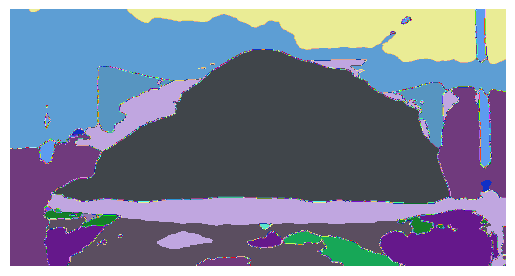

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a color map (example with random colors)
num_classes = 150  # ADE20K has 150 classes
colors = np.random.rand(num_classes, 3)
colormap = ListedColormap(colors)

# Display the segmentation map
plt.imshow(predicted_classes, cmap=colormap)
plt.axis('off')
plt.show()


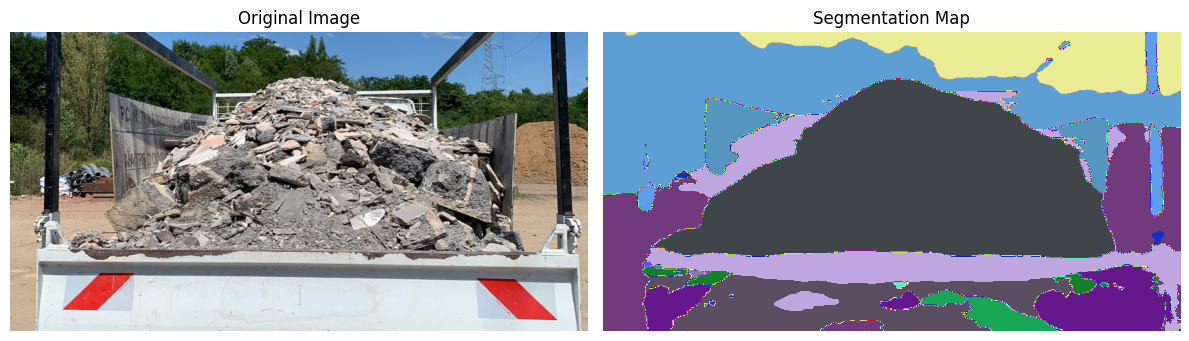

In [7]:
# Display the original image and the segmentation map
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# Segmentation Map
plt.subplot(1, 2, 2)
plt.title("Segmentation Map")
plt.imshow(predicted_classes, cmap=colormap)
plt.axis("off")

plt.tight_layout()
plt.show()

Detected dominant class ID (assumed gravat): 34


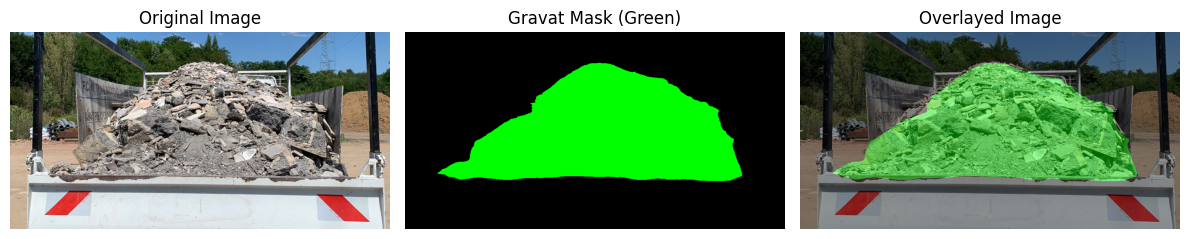

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Example: Original segmentation map (integer class IDs)
segmentation_map = predicted_classes  # Replace with your segmentation map (2D array of class IDs)

# Convert the 2D segmentation map to 3D RGB map using a fixed color palette
num_classes = 150  # Number of classes (ADE20K)
palette = np.random.randint(0, 256, (num_classes, 3), dtype=np.uint8)  # Random color palette
segmentation_map_rgb = palette[segmentation_map]  # Map each class ID to a random RGB color

# Identify the dominant color in the segmentation map
segmentation_flat = segmentation_map.flatten()
unique_classes, counts = np.unique(segmentation_flat, return_counts=True)
dominant_class_id = unique_classes[np.argmax(counts)]  # Assume gravat is the most frequent class
print(f"Detected dominant class ID (assumed gravat): {dominant_class_id}")

# Create a binary mask for the dominant class ID
binary_mask = (segmentation_map == dominant_class_id).astype(np.uint8)

# Create a green mask for visualization
color_mask = np.zeros((binary_mask.shape[0], binary_mask.shape[1], 3), dtype=np.uint8)
color_mask[binary_mask == 1] = [0, 255, 0]  # Green for gravat

# Overlay the green mask on the original image
original_image_np = np.array(image)
blended_image = (0.6 * original_image_np + 0.4 * color_mask).astype(np.uint8)

# Display the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# Gravat Mask
plt.subplot(1, 3, 2)
plt.title("Gravat Mask (Green)")
plt.imshow(color_mask)
plt.axis("off")

# Overlayed Image
plt.subplot(1, 3, 3)
plt.title("Overlayed Image")
plt.imshow(blended_image)
plt.axis("off")

plt.tight_layout()
plt.show()


# second image

In [19]:
# Load an image from a URL or local path
image_url_2 = "/kaggle/input/gravats/evacuation-gravats_cropped.png"
image_2 = Image.open(image_url_2).convert("RGB")
# Preprocess the image
inputs = feature_extractor(images=image_2, return_tensors="pt")


In [20]:
import torch

# Ensure the model is in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Shape: (batch_size, num_classes, height, width)


In [21]:
from torch.nn.functional import interpolate
import numpy as np

# Resize logits to the original image size
upsampled_logits = interpolate(
    logits,
    size=image_2.size[::-1],  # (height, width)
    mode='bilinear',
    align_corners=False
)

# Get the predicted class for each pixel
predicted_classes = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()


Detected dominant class ID (assumed gravat): 4


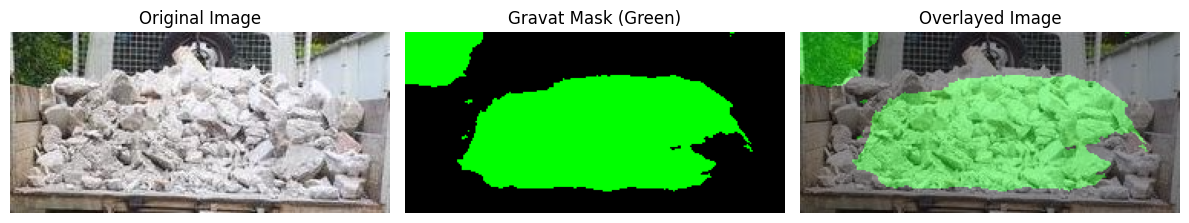

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Example: Original segmentation map (integer class IDs)
segmentation_map = predicted_classes  # Replace with your segmentation map (2D array of class IDs)

# Convert the 2D segmentation map to 3D RGB map using a fixed color palette
num_classes = 150  # Number of classes (ADE20K)
palette = np.random.randint(0, 256, (num_classes, 3), dtype=np.uint8)  # Random color palette
segmentation_map_rgb = palette[segmentation_map]  # Map each class ID to a random RGB color

# Identify the dominant color in the segmentation map
segmentation_flat = segmentation_map.flatten()
unique_classes, counts = np.unique(segmentation_flat, return_counts=True)
dominant_class_id = unique_classes[np.argmax(counts)]  # Assume gravat is the most frequent class
print(f"Detected dominant class ID (assumed gravat): {dominant_class_id}")

# Create a binary mask for the dominant class ID
binary_mask = (segmentation_map == dominant_class_id).astype(np.uint8)

# Create a green mask for visualization
color_mask = np.zeros((binary_mask.shape[0], binary_mask.shape[1], 3), dtype=np.uint8)
color_mask[binary_mask == 1] = [0, 255, 0]  # Green for gravat

# Overlay the green mask on the original image
original_image_np = np.array(image_2)
blended_image = (0.6 * original_image_np + 0.4 * color_mask).astype(np.uint8)

# Display the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_2)
plt.axis("off")

# Gravat Mask
plt.subplot(1, 3, 2)
plt.title("Gravat Mask (Green)")
plt.imshow(color_mask)
plt.axis("off")

# Overlayed Image
plt.subplot(1, 3, 3)
plt.title("Overlayed Image")
plt.imshow(blended_image)
plt.axis("off")

plt.tight_layout()
plt.show()


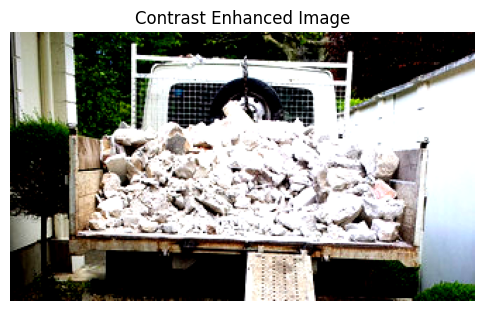

In [7]:
from PIL import ImageEnhance

# Enhance contrast
enhancer = ImageEnhance.Contrast(image_2)
contrast_image = enhancer.enhance(2.0)  # Increase contrast (adjust factor)

# Display the contrast-enhanced image
plt.figure(figsize=(6, 6))
plt.title("Contrast Enhanced Image")
plt.imshow(contrast_image)
plt.axis("off")
plt.show()


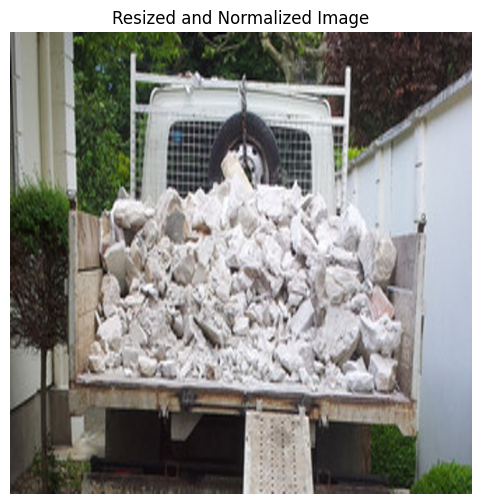

In [8]:
# Resize the image
resized_image = image_2.resize((512, 512))  # Standard size for segmentation

# Normalize pixel values
normalized_image = np.array(resized_image) / 255.0  # Scale to [0, 1]

# Display the preprocessed image
plt.figure(figsize=(6, 6))
plt.title("Resized and Normalized Image")
plt.imshow(normalized_image)
plt.axis("off")
plt.show()


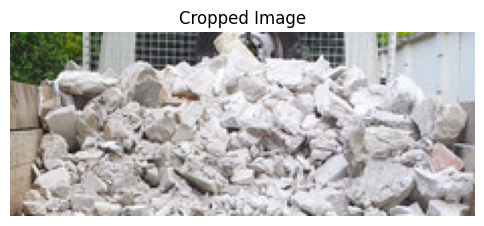

In [9]:
from PIL import Image

# Load the image
cropped_image = image_2.crop((50, 50, image_2.width - 50, image_2.height - 50))  # Adjust cropping bounds

# Display the cropped image
plt.figure(figsize=(6, 6))
plt.title("Cropped Image")
plt.imshow(cropped_image)
plt.axis("off")
plt.show()


# Preprocessing and modeling

Detected dominant class ID (assumed gravat): 34


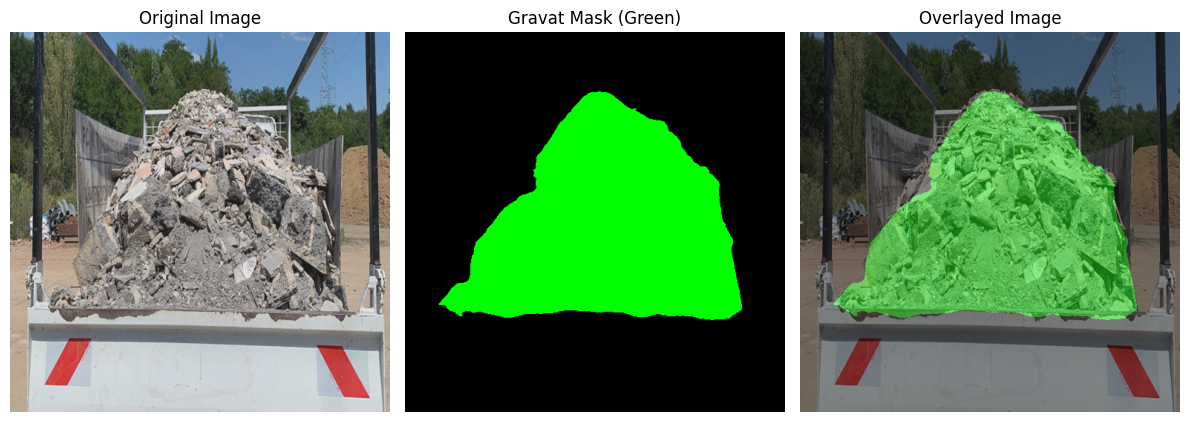

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import torch
from torch.nn.functional import interpolate
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# Load the feature extractor and model
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model.eval()  # Ensure the model is in evaluation mode

# --- Preprocessing Function ---
def preprocess_image(image_path, contrast_factor=0.8, target_size=(512, 512)):
    """
    Preprocesses the image by enhancing contrast, resizing, and normalizing.
    Args:
        image_path (str): Path to the input image.
        contrast_factor (float): Factor for contrast enhancement.
        target_size (tuple): Desired image size for resizing.
    Returns:
        PIL.Image: Preprocessed image.
    """
    # Load and enhance contrast
    image = Image.open(image_path).convert("RGB")
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(contrast_factor)
    
    # Resize the image
    resized_image = enhanced_image.resize(target_size)
    return resized_image

# --- Modeling Function ---
def segment_image(image):
    """
    Segments the image using the SegFormer model.
    Args:
        image (PIL.Image): Preprocessed image.
    Returns:
        np.ndarray: Predicted segmentation map (2D array of class IDs).
    """
    # Preprocess the image with feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # (batch_size, num_classes, height, width)
    
    # Resize logits to match the original image size
    upsampled_logits = interpolate(
        logits,
        size=image.size[::-1],  # (height, width)
        mode="bilinear",
        align_corners=False,
    )
    
    # Get predicted class for each pixel
    predicted_classes = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
    return predicted_classes

# --- Visualization Function ---
def visualize_segmentation(image, segmentation_map, palette=None):
    """
    Visualizes the original image, segmentation map, and overlayed image.
    Args:
        image (PIL.Image): Original image.
        segmentation_map (np.ndarray): Predicted segmentation map.
        palette (np.ndarray): Color palette for the segmentation map.
    """
    # Generate a random color palette if not provided
    num_classes = 150  # ADE20K has 150 classes
    if palette is None:
        palette = np.random.randint(0, 256, (num_classes, 3), dtype=np.uint8)
    
    # Convert segmentation map to RGB
    segmentation_map_rgb = palette[segmentation_map]

    # Identify the dominant class ID
    segmentation_flat = segmentation_map.flatten()
    unique_classes, counts = np.unique(segmentation_flat, return_counts=True)
    dominant_class_id = unique_classes[np.argmax(counts)]
    print(f"Detected dominant class ID (assumed gravat): {dominant_class_id}")

    # Create a binary mask for the dominant class ID
    binary_mask = (segmentation_map == dominant_class_id).astype(np.uint8)

    # Create a green mask for visualization
    color_mask = np.zeros((binary_mask.shape[0], binary_mask.shape[1], 3), dtype=np.uint8)
    color_mask[binary_mask == 1] = [0, 255, 0]  # Green for gravat

    # Overlay the green mask on the original image
    original_image_np = np.array(image)
    blended_image = (0.6 * original_image_np + 0.4 * color_mask).astype(np.uint8)

    # Display results
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    # Gravat Mask
    plt.subplot(1, 3, 2)
    plt.title("Gravat Mask (Green)")
    plt.imshow(color_mask)
    plt.axis("off")

    # Overlayed Image
    plt.subplot(1, 3, 3)
    plt.title("Overlayed Image")
    plt.imshow(blended_image)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- Main Pipeline ---
def process_and_segment(image_path):
    """
    Full pipeline for preprocessing, segmentation, and visualization.
    Args:
        image_path (str): Path to the input image.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    
    # Perform segmentation
    segmentation_map = segment_image(preprocessed_image)
    
    # Visualize results
    visualize_segmentation(preprocessed_image, segmentation_map)

# --- Example Usage ---
image_path = "/kaggle/input/gravats/camion-gravats-2tonnes.jpg"
process_and_segment(image_path)


Detected dominant class ID (assumed gravat): 4


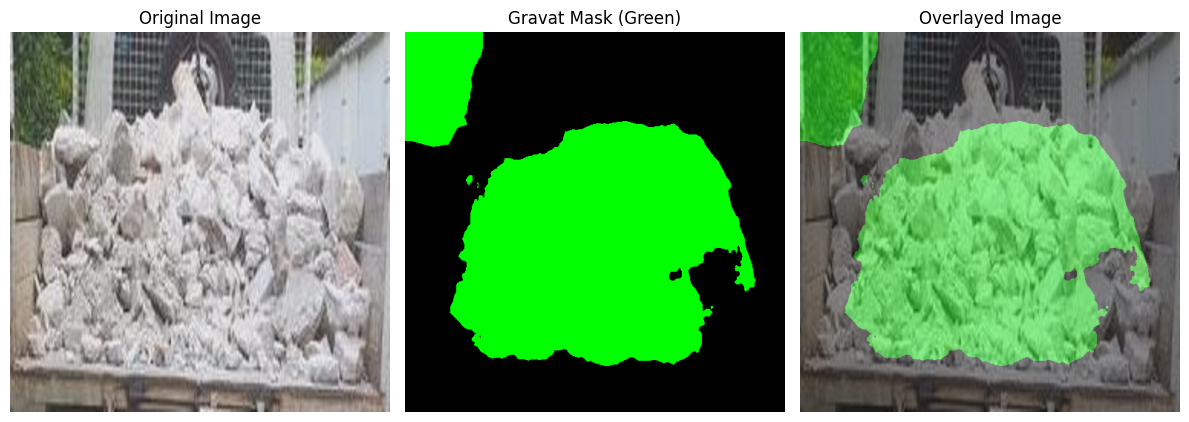

In [18]:
# --- Example Usage ---
image_path = "/kaggle/input/gravats/evacuation-gravats_cropped.png"
process_and_segment(image_path)


# Gravat Segmentation Pipeline

Detected dominant class ID (assumed gravat): 34


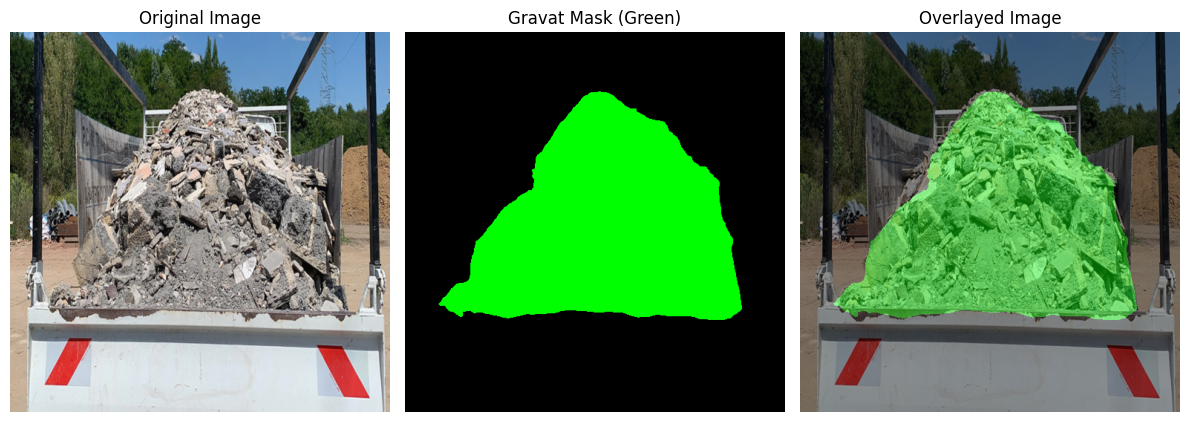

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import torch
from torch.nn.functional import interpolate
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import cv2

# --- Load the model and feature extractor ---
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model.eval()  # Ensure the model is in evaluation mode

# --- Dynamic Contrast Adjustment Function ---
def dynamic_contrast(image, base_factor=1.0):
    """
    Dynamically adjust contrast based on image brightness.
    Args:
        image (PIL.Image): Input image.
        base_factor (float): Base contrast adjustment factor.
    Returns:
        PIL.Image: Contrast-enhanced image.
    """
    brightness = np.mean(np.array(image))  # Calculate mean brightness
    factor = base_factor + (128 - brightness) / 128  # Adjust factor dynamically
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)

# --- Preprocessing Function ---
def preprocess_image(image_path, target_size=(512, 512)):
    """
    Preprocesses the image by dynamically adjusting contrast and resizing.
    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Desired image size for resizing.
    Returns:
        PIL.Image: Preprocessed image.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Enhance contrast dynamically
    enhanced_image = dynamic_contrast(image)

    # Resize the image
    resized_image = enhanced_image.resize(target_size)
    return resized_image

# --- Segmentation Function ---
def segment_image(image):
    """
    Segments the image using the SegFormer model.
    Args:
        image (PIL.Image): Preprocessed image.
    Returns:
        np.ndarray: Predicted segmentation map (2D array of class IDs).
    """
    # Preprocess the image with feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # (batch_size, num_classes, height, width)
    
    # Resize logits to match the original image size
    upsampled_logits = interpolate(
        logits,
        size=image.size[::-1],  # (height, width)
        mode="bilinear",
        align_corners=False,
    )
    
    # Get predicted class for each pixel
    predicted_classes = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()
    return predicted_classes

# --- Post-Processing Function ---
def post_process_mask(binary_mask):
    """
    Apply morphological operations to refine the binary mask.
    Args:
        binary_mask (np.ndarray): Binary mask of the gravat region.
    Returns:
        np.ndarray: Refined binary mask.
    """
    kernel = np.ones((5, 5), np.uint8)  # Define a kernel size
    refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    return refined_mask

# --- Visualization Function ---
def visualize_segmentation(image, segmentation_map, palette=None):
    """
    Visualizes the original image, segmentation map, and overlayed image.
    Args:
        image (PIL.Image): Original image.
        segmentation_map (np.ndarray): Predicted segmentation map.
        palette (np.ndarray): Color palette for the segmentation map.
    """
    # Generate a random color palette if not provided
    num_classes = 150  # ADE20K has 150 classes
    if palette is None:
        palette = np.random.randint(0, 256, (num_classes, 3), dtype=np.uint8)
    
    # Convert segmentation map to RGB
    segmentation_map_rgb = palette[segmentation_map]

    # Identify the dominant class ID
    segmentation_flat = segmentation_map.flatten()
    unique_classes, counts = np.unique(segmentation_flat, return_counts=True)
    dominant_class_id = unique_classes[np.argmax(counts)]
    print(f"Detected dominant class ID (assumed gravat): {dominant_class_id}")

    # Create a binary mask for the dominant class ID
    binary_mask = (segmentation_map == dominant_class_id).astype(np.uint8)

    # Post-process the binary mask
    refined_mask = post_process_mask(binary_mask)

    # Create a green mask for visualization
    color_mask = np.zeros((refined_mask.shape[0], refined_mask.shape[1], 3), dtype=np.uint8)
    color_mask[refined_mask == 1] = [0, 255, 0]  # Green for gravat

    # Overlay the green mask on the original image
    original_image_np = np.array(image)
    blended_image = (0.6 * original_image_np + 0.4 * color_mask).astype(np.uint8)

    # Display results
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    # Gravat Mask
    plt.subplot(1, 3, 2)
    plt.title("Gravat Mask (Green)")
    plt.imshow(color_mask)
    plt.axis("off")

    # Overlayed Image
    plt.subplot(1, 3, 3)
    plt.title("Overlayed Image")
    plt.imshow(blended_image)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- Full Pipeline ---
def process_and_segment(image_path):
    """
    Full pipeline for preprocessing, segmentation, and visualization.
    Args:
        image_path (str): Path to the input image.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    
    # Perform segmentation
    segmentation_map = segment_image(preprocessed_image)
    
    # Visualize results
    visualize_segmentation(preprocessed_image, segmentation_map)

# --- Example Usage ---
image_path = "/kaggle/input/gravats/camion-gravats-2tonnes.jpg"  # Replace with the path to your image
process_and_segment(image_path)


Detected dominant class ID (assumed gravat): 34
Mask saved to /kaggle/working/gravat_mask.png
Overlayed image saved to /kaggle/working/gravat_overlay.png


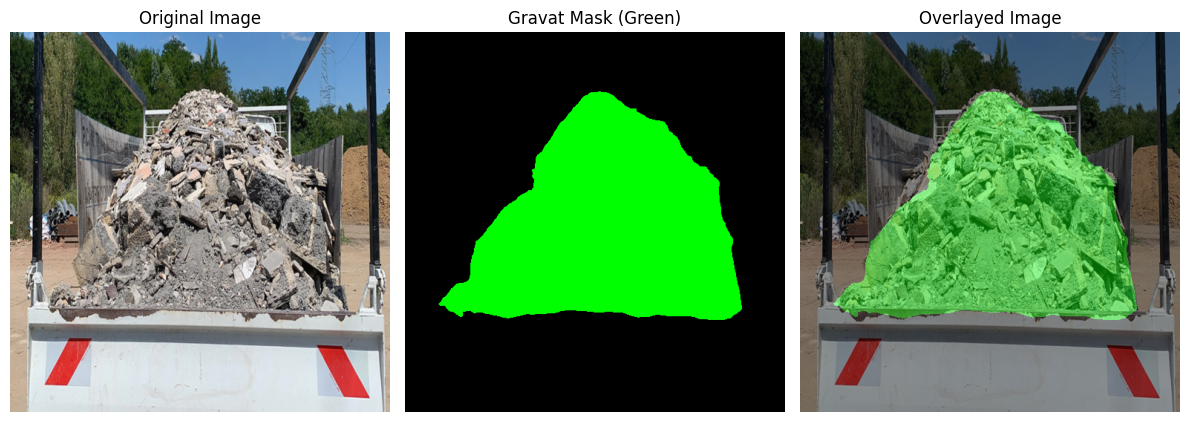

In [35]:
def save_mask(binary_mask, output_path):
    """
    Saves the binary mask as an image.
    Args:
        binary_mask (np.ndarray): Binary mask of the gravat region.
        output_path (str): Path to save the mask image.
    """
    mask_image = Image.fromarray((binary_mask * 255).astype(np.uint8))  # Convert to a binary image
    mask_image.save(output_path)
    print(f"Mask saved to {output_path}")

def save_overlay(image, color_mask, output_path):
    """
    Saves the overlayed image (original image with mask) as an image.
    Args:
        image (PIL.Image): Original image.
        color_mask (np.ndarray): RGB mask overlay.
        output_path (str): Path to save the overlayed image.
    """
    original_image_np = np.array(image)
    blended_image = (0.6 * original_image_np + 0.4 * color_mask).astype(np.uint8)
    blended_image_pil = Image.fromarray(blended_image)
    blended_image_pil.save(output_path)
    print(f"Overlayed image saved to {output_path}")

# --- Visualization Function with Save ---
def visualize_and_save_segmentation(image, segmentation_map, mask_output_path, overlay_output_path, palette=None):
    """
    Visualizes and saves the original image, segmentation map, and overlayed image.
    Args:
        image (PIL.Image): Original image.
        segmentation_map (np.ndarray): Predicted segmentation map.
        mask_output_path (str): Path to save the mask image.
        overlay_output_path (str): Path to save the overlayed image.
        palette (np.ndarray): Color palette for the segmentation map.
    """
    # Generate a random color palette if not provided
    num_classes = 150  # ADE20K has 150 classes
    if palette is None:
        palette = np.random.randint(0, 256, (num_classes, 3), dtype=np.uint8)
    
    # Convert segmentation map to RGB
    segmentation_map_rgb = palette[segmentation_map]

    # Identify the dominant class ID
    segmentation_flat = segmentation_map.flatten()
    unique_classes, counts = np.unique(segmentation_flat, return_counts=True)
    dominant_class_id = unique_classes[np.argmax(counts)]
    print(f"Detected dominant class ID (assumed gravat): {dominant_class_id}")

    # Create a binary mask for the dominant class ID
    binary_mask = (segmentation_map == dominant_class_id).astype(np.uint8)

    # Post-process the binary mask
    refined_mask = post_process_mask(binary_mask)

    # Create a green mask for visualization
    color_mask = np.zeros((refined_mask.shape[0], refined_mask.shape[1], 3), dtype=np.uint8)
    color_mask[refined_mask == 1] = [0, 255, 0]  # Green for gravat

    # Save the binary mask
    save_mask(refined_mask, mask_output_path)

    # Save the overlayed image
    save_overlay(image, color_mask, overlay_output_path)

    # Display results
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    # Gravat Mask
    plt.subplot(1, 3, 2)
    plt.title("Gravat Mask (Green)")
    plt.imshow(color_mask)
    plt.axis("off")

    # Overlayed Image
    plt.subplot(1, 3, 3)
    plt.title("Overlayed Image")
    plt.imshow((0.6 * np.array(image) + 0.4 * color_mask).astype(np.uint8))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- Full Pipeline with Save ---
def process_and_segment_with_save(image_path, mask_output_path, overlay_output_path):
    """
    Full pipeline for preprocessing, segmentation, and saving results.
    Args:
        image_path (str): Path to the input image.
        mask_output_path (str): Path to save the binary mask image.
        overlay_output_path (str): Path to save the overlayed image.
    """
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    
    # Perform segmentation
    segmentation_map = segment_image(preprocessed_image)
    
    # Visualize and save results
    visualize_and_save_segmentation(preprocessed_image, segmentation_map, mask_output_path, overlay_output_path)

# --- Example Usage ---
image_path = "/kaggle/input/gravats/camion-gravats-2tonnes.jpg"  # Replace with your image path
mask_output_path = "/kaggle/working/gravat_mask.png"  # Path to save the mask
overlay_output_path = "/kaggle/working/gravat_overlay.png"  # Path to save the overlayed image

process_and_segment_with_save(image_path, mask_output_path, overlay_output_path)


In [37]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('/kaggle/working/gravat_mask.png')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection
edges = cv2.Canny(gray, 50, 100)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour is the reference object
reference_contour = max(contours, key=cv2.contourArea)

# Calculate bounding box of the reference object
ref_x, ref_y, ref_w, ref_h = cv2.boundingRect(reference_contour)

# Known width of the reference object (e.g., in centimeters)
known_width = 5.0  # Example value

# Calculate pixels per metric
pixels_per_metric = ref_w / known_width

# Process other contours (e.g., target object)
for contour in contours:
    if contour is not reference_contour:
        # Calculate bounding box of the target object
        x, y, w, h = cv2.boundingRect(contour)
        
        # Compute real-world dimensions
        real_width = w / pixels_per_metric
        real_height = h / pixels_per_metric
        
        # Calculate surface area
        surface_area = real_width * real_height
        print(f"Estimated Surface Area: {surface_area:.2f} square centimeters")


In [38]:
import cv2
import numpy as np
from PIL import Image

def calculate_surface_area(mask_path, reference_object_width=10.0):
    """
    Calculate the surface area of the white region in a binary mask using a reference object.
    Args:
        mask_path (str): Path to the binary mask image.
        reference_object_width (float): Width of the reference object in real-world units (e.g., cm).
    Returns:
        float: Estimated surface area in square centimeters.
    """
    # Load the binary mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError("Could not read the image. Check the file path.")

    # Ensure the image is binary
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Ensure there are contours detected
    if len(contours) == 0:
        raise ValueError("No contours found in the mask image.")

    # Assume the largest contour is the gravat region
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Calculate the bounding rectangle for the reference object (if available)
    # In this example, we use the entire image as the reference
    h, w = binary_mask.shape  # Height and width of the image in pixels

    # Calculate pixels per metric (based on the known reference object width)
    pixels_per_metric = w / reference_object_width  # Pixels per cm

    # Calculate the area of the gravat region in pixels
    gravat_area_pixels = cv2.contourArea(largest_contour)

    # Convert pixel area to real-world area in square centimeters
    area_per_pixel = (1 / pixels_per_metric) ** 2  # Area of one pixel in cm²
    gravat_area_cm2 = gravat_area_pixels * area_per_pixel

    return gravat_area_cm2

# --- Example Usage ---
mask_path = "gravat_mask.png"  # Path to the binary mask
reference_width = 100.0  # Example: Assume the image width corresponds to 100 cm in the real world

# Calculate the surface area
try:
    surface_area = calculate_surface_area(mask_path, reference_width)
    print(f"Estimated Surface Area: {surface_area:.2f} square centimeters")
except ValueError as e:
    print(f"Error: {e}")


Estimated Surface Area: 3006.06 square centimeters


In [39]:
import numpy as np
from PIL import Image

mask = Image.open("gravat_mask.png").convert("L")
mask_array = np.array(mask)
white_pixel_count = np.sum(mask_array == 255)
print(f"White Pixel Count: {white_pixel_count}")


White Pixel Count: 79359


In [40]:
image_width_pixels = mask_array.shape[1]
reference_width_cm = 100.0  # Example real-world width in cm
pixel_scale = reference_width_cm / image_width_pixels
area_per_pixel = pixel_scale ** 2
estimated_area = white_pixel_count * area_per_pixel
print(f"Manual Surface Area: {estimated_area:.2f} square centimeters")


Manual Surface Area: 3027.31 square centimeters
